## Applied ML for baseball:

#### By Thomas Maxence Franco 
Submitted to the Faculty of Science in partial fulfillment of the requirements for the degree of 
#### Master of Modeling for Science and Engineering 
at the 
#### UNIVERSITAT AUTÒNOMA DE BARCELONA 
Directed by 
Tomás Manuel Margalef Burrull
July 2024


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = "C:\\Users\\mfran\\OneDrive - UAB\\Masters\\Thesis\\Batting\\tables\\advperf_all.csv"
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

In [4]:
df.head()

,Name,AAV,catcher,year,Age,stayed_same_team,G,PA,HR,R,...,BsR_2,WAR_2,wRAA_2,UBR_2,WPA_2,Clutch_2,Barrel%_2,HardHit%_2,xBA_2,xSLG_2
0,Shohei Ohtani,35.122807,False,2024,29,False,135,599,44,102,...,-1.666291,3.607169,31.681486,0.2,2.110040,-0.410867,0.168224,0.497664,0.275,0.549
1,Cody Bellinger,26.666667,False,2024,28,True,130,556,26,95,...,2.793818,1.489862,-11.230229,2.7,-1.326695,-0.436589,0.083333,0.380556,0.213,0.354
2,Teoscar Hernandez,23.500000,False,2024,31,False,160,678,26,70,...,0.522415,2.920516,16.154087,0.2,0.921679,0.530959,0.149856,0.527378,0.265,0.501
3,Matt Chapman,18.000000,False,2024,31,False,140,581,17,66,...,1.042438,3.891624,10.354405,2.2,0.159277,-0.651814,0.128686,0.506702,0.234,0.440
4,Rhys Hoskins,17.000000,False,2024,31,False,0,0,0,0,...,-2.598383,2.366255,18.912618,-2.6,1.471186,-0.352039,0.110588,0.442353,0.239,0.445


## Data Cleaning

Missing values for Barrel%_2, HardHit%_2, xBA_2, xSLG_2 are due to the lack of Statcast equipment for the 2014 and previous season to that. To not lose 59 rows of valuable info I will use the stats we have for those columns from the 2015 season. There is no real variance in them from season to season as the next lines of code will show:

In [5]:
df['Barrel_diff'] = df['Barrel%'] - df['Barrel%_2']

In [6]:
average_diff = df['Barrel_diff'].mean()
print("Average Difference: ", average_diff)

Average Difference:  0.003107339103641457


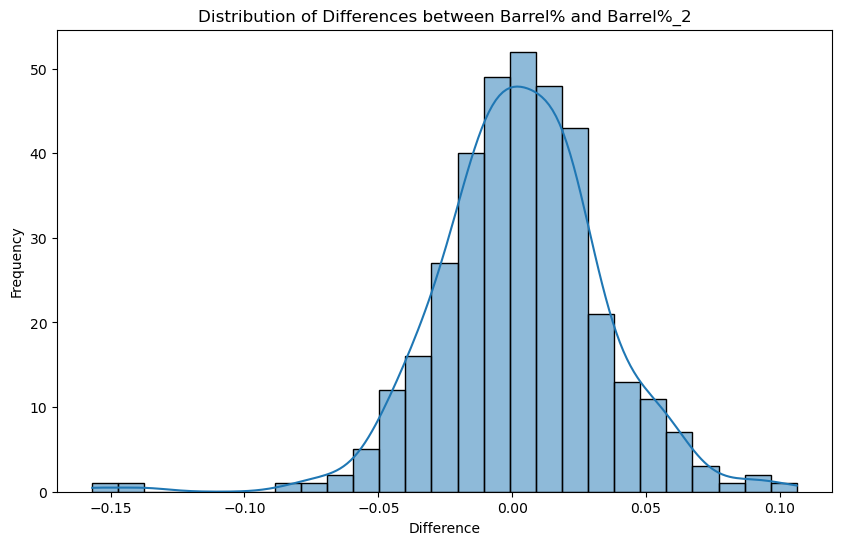

In [7]:
# Detailed distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Barrel_diff'], kde=True)
plt.title('Distribution of Differences between Barrel% and Barrel%_2')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [8]:
df['HardHit_diff'] = df['HardHit%'] - df['HardHit%_2']
average_diffhh = df['HardHit_diff'].mean()
print("Average Difference: ", average_diffhh)

Average Difference:  0.005074780392156861


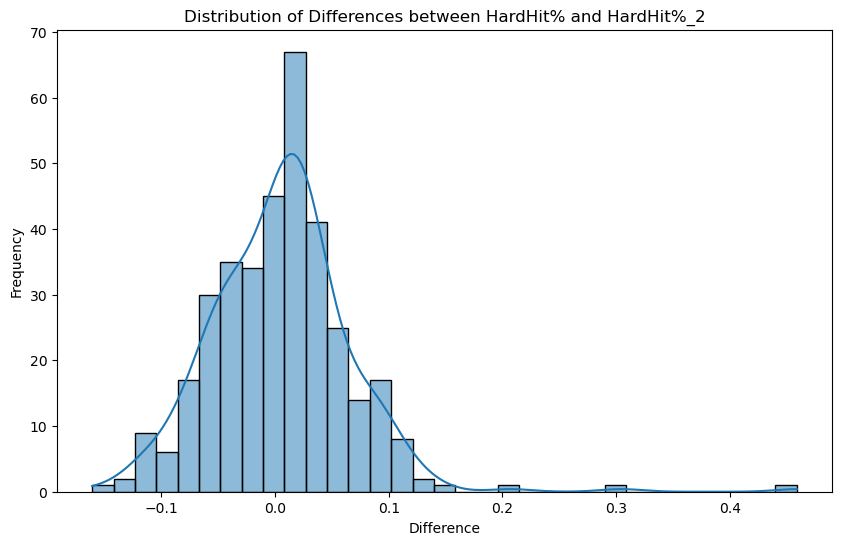

In [9]:
# Detailed distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['HardHit_diff'], kde=True)
plt.title('Distribution of Differences between HardHit% and HardHit%_2')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [10]:
df['xBA_diff'] = df['xBA'] - df['xBA_2']
average_xBA = df['xBA_diff'].mean()
print("Average Difference: ", average_xBA)

Average Difference:  -0.0027002801120448176


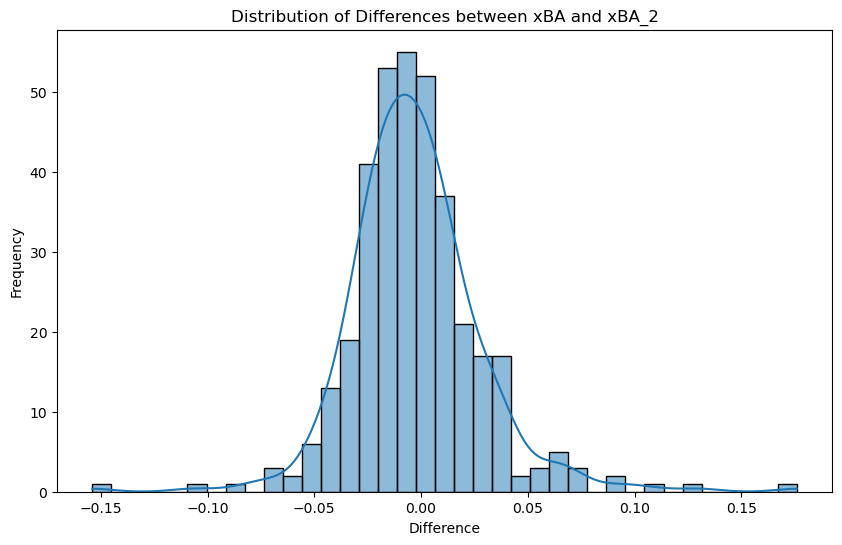

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df['xBA_diff'], kde=True)
plt.title('Distribution of Differences between xBA and xBA_2')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [12]:
df['xSLG_diff'] = df['xSLG'] - df['xSLG_2']
average_xSLG = df['xSLG_diff'].mean()
print("Average Difference: ", average_xSLG)

Average Difference:  -0.0036218487394958014


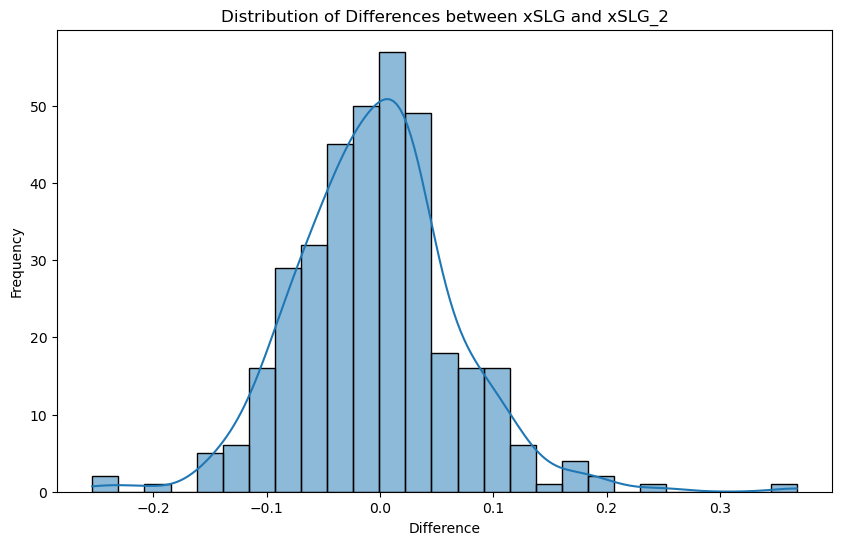

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['xSLG_diff'], kde=True)
plt.title('Distribution of Differences between xSLG and xSLG_2')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [14]:
columns_to_drop = ['Barrel_diff', 'HardHit_diff', 'xBA_diff', 'xSLG_diff']

df.drop(columns=columns_to_drop, inplace=True)

In [15]:
columns_to_fill = ['Barrel%_2', 'HardHit%_2', 'xBA_2', 'xSLG_2']
corresponding_columns = ['Barrel%', 'HardHit%', 'xBA', 'xSLG']

rows_with_missing_values=df[df[columns_to_fill].isnull().any(axis=1)]
relevant_columns = columns_to_fill + corresponding_columns


print(rows_with_missing_values[relevant_columns])


     Barrel%_2  HardHit%_2  xBA_2  xSLG_2   Barrel%  HardHit%    xBA   xSLG
209        NaN         NaN    NaN     NaN  0.072539  0.409326  0.251  0.485
303        NaN         NaN    NaN     NaN  0.014085  0.225352  0.268  0.353
361        NaN         NaN    NaN     NaN  0.104628  0.448692  0.294  0.546
362        NaN         NaN    NaN     NaN  0.167568  0.462162  0.262  0.589
363        NaN         NaN    NaN     NaN  0.028139  0.346320  0.263  0.374
..         ...         ...    ...     ...       ...       ...    ...    ...
415        NaN         NaN    NaN     NaN  0.014493  0.275362  0.205  0.293
416        NaN         NaN    NaN     NaN  0.079235  0.311475  0.238  0.435
417        NaN         NaN    NaN     NaN  0.000000  0.178808  0.231  0.285
418        NaN         NaN    NaN     NaN  0.093023  0.372093  0.186  0.335
419        NaN         NaN    NaN     NaN  0.000000  0.203704  0.262  0.322

[61 rows x 8 columns]


In [16]:
for col_to_fill, corresponding_col in zip(columns_to_fill, corresponding_columns):
    df[col_to_fill] = df[col_to_fill].fillna(df[corresponding_col])


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

In [18]:
corresponding_columns  = ['Barrel%_2', 'HardHit%_2', 'xBA_2', 'xSLG_2']
columns_to_fill = ['Barrel%', 'HardHit%', 'xBA', 'xSLG']
for col_to_fill, corresponding_col in zip(columns_to_fill, corresponding_columns):
    df[col_to_fill] = df[col_to_fill].fillna(df[corresponding_col])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

The same thought process wll be done for the other columns

In [19]:
columns_to_fill = ["BABIP","wOBA","wRC+","Off","Def","BsR","WAR","wRAA","UBR","WPA","Clutch"]
corresponding_columns = ["BABIP_2","wOBA_2","wRC+_2","Off_2","Def_2","BsR_2","WAR_2","wRAA_2","UBR_2","WPA_2","Clutch_2"]

rows_with_missing_values=df[df[columns_to_fill].isnull().any(axis=1)]
relevant_columns = columns_to_fill + corresponding_columns


print(rows_with_missing_values[relevant_columns])

     BABIP  wOBA  wRC+  Off  Def  BsR  WAR  wRAA  UBR  WPA  ...    wOBA_2  \
4      NaN   NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  0.345172   
227    NaN   NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  0.299453   

         wRC+_2      Off_2      Def_2     BsR_2     WAR_2     wRAA_2  UBR_2  \
4    122.328017  14.834363 -15.319128 -2.598383  2.366255  18.912618   -2.6   
227   84.442374  -5.020572  -4.698701  0.145992 -0.142697  -3.380756    0.4   

        WPA_2  Clutch_2  
4    1.471186 -0.352039  
227 -0.633888 -0.034693  

[2 rows x 22 columns]


In [20]:
for col_to_fill, corresponding_col in zip(columns_to_fill, corresponding_columns):
    df[col_to_fill] = df[col_to_fill].fillna(df[corresponding_col])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

In [22]:
corresponding_columns = ["BABIP","wOBA","wRC+","Off","Def","BsR","WAR","wRAA","UBR","WPA","Clutch"]
columns_to_fill= ["BABIP_2","wOBA_2","wRC+_2","Off_2","Def_2","BsR_2","WAR_2","wRAA_2","UBR_2","WPA_2","Clutch_2"]

rows_with_missing_values=df[df[columns_to_fill].isnull().any(axis=1)]
relevant_columns = columns_to_fill + corresponding_columns


print(rows_with_missing_values[relevant_columns])

     BABIP_2  wOBA_2  wRC+_2  Off_2  Def_2  BsR_2  WAR_2  wRAA_2  UBR_2  \
209      NaN     NaN     NaN    NaN    NaN    NaN    NaN     NaN    NaN   
303      NaN     NaN     NaN    NaN    NaN    NaN    NaN     NaN    NaN   
403      NaN     NaN     NaN    NaN    NaN    NaN    NaN     NaN    NaN   

     WPA_2  ...      wOBA        wRC+        Off       Def       BsR  \
209    NaN  ...  0.331348  106.267690   1.970928 -3.108211 -0.344500   
303    NaN  ...  0.343312  108.625662   1.923657  3.995705 -1.391168   
403    NaN  ...  0.409689  167.413302  14.665447  0.656869 -0.078431   

          WAR       wRAA  UBR       WPA    Clutch  
209  0.757577   2.761745 -1.6 -0.105784 -0.633847  
303  1.612301   5.658074 -0.8  0.888268  0.281035  
403  2.281873  14.570313  0.3  0.830802 -0.697624  

[3 rows x 22 columns]


In [23]:
for col_to_fill, corresponding_col in zip(columns_to_fill, corresponding_columns):
    df[col_to_fill] = df[col_to_fill].fillna(df[corresponding_col])

df.head()

,Name,AAV,catcher,year,Age,stayed_same_team,G,PA,HR,R,...,BsR_2,WAR_2,wRAA_2,UBR_2,WPA_2,Clutch_2,Barrel%_2,HardHit%_2,xBA_2,xSLG_2
0,Shohei Ohtani,35.122807,False,2024,29,False,135,599,44,102,...,-1.666291,3.607169,31.681486,0.2,2.110040,-0.410867,0.168224,0.497664,0.275,0.549
1,Cody Bellinger,26.666667,False,2024,28,True,130,556,26,95,...,2.793818,1.489862,-11.230229,2.7,-1.326695,-0.436589,0.083333,0.380556,0.213,0.354
2,Teoscar Hernandez,23.500000,False,2024,31,False,160,678,26,70,...,0.522415,2.920516,16.154087,0.2,0.921679,0.530959,0.149856,0.527378,0.265,0.501
3,Matt Chapman,18.000000,False,2024,31,False,140,581,17,66,...,1.042438,3.891624,10.354405,2.2,0.159277,-0.651814,0.128686,0.506702,0.234,0.440
4,Rhys Hoskins,17.000000,False,2024,31,False,0,0,0,0,...,-2.598383,2.366255,18.912618,-2.6,1.471186,-0.352039,0.110588,0.442353,0.239,0.445


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   G                 420 non-null    int64  
 7   PA                420 non-null    int64  
 8   HR                420 non-null    int64  
 9   R                 420 non-null    int64  
 10  RBI               420 non-null    int64  
 11  AVG               420 non-null    float64
 12  OBP               420 non-null    float64
 13  SLG               420 non-null    float64
 14  GDP               420 non-null    int64  
 15  H                 420 non-null    int64  
 16  OPS               420 non-null    float64
 1

At this point we have 420 entries and 60 variables. I want to follow the 1:10 thumb rule for the amount of variables we can use in our model. We can reduce the number of variables by making accumulated columns from the integer variables and some float variables too. These can be added as it is representative of the added performance of the last two seasons. The variables used are presented in the defined 'pairs'. The created columns and those that werent modified will be stored in a new df. 

In [25]:
pairs = [
    ('G', 'G_2'),
    ('PA', 'PA_2'),
    ('HR', 'HR_2'),
    ('R', 'R_2'),
    ('RBI', 'RBI_2'),
    ('H', 'H_2'),
    ('GDP', 'GDP_2'),
    ('WAR', 'WAR_2'),
    ('WPA', 'WPA_2'),
    ('Clutch', 'Clutch_2'),
    ('wRAA', 'wRAA_2'),
    ('Off', 'Off_2'),
    ('Def', 'Def_2'),
    ('BsR', 'BsR_2'),
    ('UBR', 'UBR_2')
]

summed_columns = {f"{col1}_{col2.split('_')[-1]}_sum": df[col1] + df[col2] for col1, col2 in pairs}

summed_df = pd.DataFrame(summed_columns)

used_columns = [col for pair in pairs for col in pair]

remaining_columns = [col for col in df.columns if col not in used_columns]

new_df = pd.concat([df[remaining_columns], summed_df], axis=1)

new_df.head()


,Name,AAV,catcher,year,Age,stayed_same_team,AVG,OBP,SLG,OPS,...,H_2_sum,GDP_2_sum,WAR_2_sum,WPA_2_sum,Clutch_2_sum,wRAA_2_sum,Off_2_sum,Def_2_sum,BsR_2_sum,UBR_2_sum
0,Shohei Ohtani,35.122807,False,2024,29,False,0.303823,0.412458,0.653924,1.066381,...,311,15,10.151636,6.240769,-2.491475,88.944333,89.395896,-30.895061,0.799437,1.9
1,Cody Bellinger,26.666667,False,2024,28,True,0.306613,0.356115,0.525050,0.881165,...,259,14,5.780272,1.137959,-1.128007,12.707613,18.272228,1.275846,5.240613,4.2
2,Teoscar Hernandez,23.500000,False,2024,31,False,0.257600,0.305310,0.435200,0.740510,...,294,24,4.722464,-0.388117,-1.083435,15.101525,17.941033,-12.122298,-3.865963,-3.9
3,Matt Chapman,18.000000,False,2024,31,False,0.239686,0.330465,0.424361,0.754826,...,245,11,6.931136,-1.107047,-2.354770,15.177320,19.770645,8.323663,0.299996,3.5
4,Rhys Hoskins,17.000000,False,2024,31,False,0.000000,0.000000,0.000000,0.000000,...,145,12,4.732510,2.942371,-0.704078,37.825236,29.668726,-30.638255,-5.196766,-5.2


In [26]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              420 non-null    object 
 1   AAV               420 non-null    float64
 2   catcher           420 non-null    bool   
 3   year              420 non-null    int64  
 4   Age               420 non-null    int64  
 5   stayed_same_team  420 non-null    bool   
 6   AVG               420 non-null    float64
 7   OBP               420 non-null    float64
 8   SLG               420 non-null    float64
 9   OPS               420 non-null    float64
 10  PlayerId          420 non-null    int64  
 11  AVG_2             420 non-null    float64
 12  OBP_2             420 non-null    float64
 13  SLG_2             420 non-null    float64
 14  OPS_2             420 non-null    float64
 15  SB_success        420 non-null    float64
 16  SB_success_2      420 non-null    float64
 1

In [27]:
removed_columns = ['PlayerId', 'year']
selected_columns = new_df.columns[~new_df.columns.isin(removed_columns)]

df2 = new_df.drop(columns=removed_columns).copy()

df2.head()

,Name,AAV,catcher,Age,stayed_same_team,AVG,OBP,SLG,OPS,AVG_2,...,H_2_sum,GDP_2_sum,WAR_2_sum,WPA_2_sum,Clutch_2_sum,wRAA_2_sum,Off_2_sum,Def_2_sum,BsR_2_sum,UBR_2_sum
0,Shohei Ohtani,35.122807,False,29,False,0.303823,0.412458,0.653924,1.066381,0.273038,...,311,15,10.151636,6.240769,-2.491475,88.944333,89.395896,-30.895061,0.799437,1.9
1,Cody Bellinger,26.666667,False,28,True,0.306613,0.356115,0.525050,0.881165,0.210317,...,259,14,5.780272,1.137959,-1.128007,12.707613,18.272228,1.275846,5.240613,4.2
2,Teoscar Hernandez,23.500000,False,31,False,0.257600,0.305310,0.435200,0.740510,0.266533,...,294,24,4.722464,-0.388117,-1.083435,15.101525,17.941033,-12.122298,-3.865963,-3.9
3,Matt Chapman,18.000000,False,31,False,0.239686,0.330465,0.424361,0.754826,0.228625,...,245,11,6.931136,-1.107047,-2.354770,15.177320,19.770645,8.323663,0.299996,3.5
4,Rhys Hoskins,17.000000,False,31,False,0.000000,0.000000,0.000000,0.000000,0.246000,...,145,12,4.732510,2.942371,-0.704078,37.825236,29.668726,-30.638255,-5.196766,-5.2


In [28]:
from sklearn.feature_selection import VarianceThreshold


numeric_df = df2.select_dtypes(include=['float64', 'int64'])

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(numeric_df)

selected_columns = numeric_df.columns[selector.get_support(indices=True)]
selected_numeric_df = numeric_df[selected_columns]

print(selected_columns)


Index(['AAV', 'Age', 'SB_success', 'SB_success_2', 'wRC+', 'wRC+_2', 'G_2_sum',
       'PA_2_sum', 'HR_2_sum', 'R_2_sum', 'RBI_2_sum', 'H_2_sum', 'GDP_2_sum',
       'WAR_2_sum', 'WPA_2_sum', 'Clutch_2_sum', 'wRAA_2_sum', 'Off_2_sum',
       'Def_2_sum', 'BsR_2_sum', 'UBR_2_sum'],
      dtype='object')


C:\Users\mfran\AppData\Local\Temp\ipykernel_12116\79026121.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df2.corr()


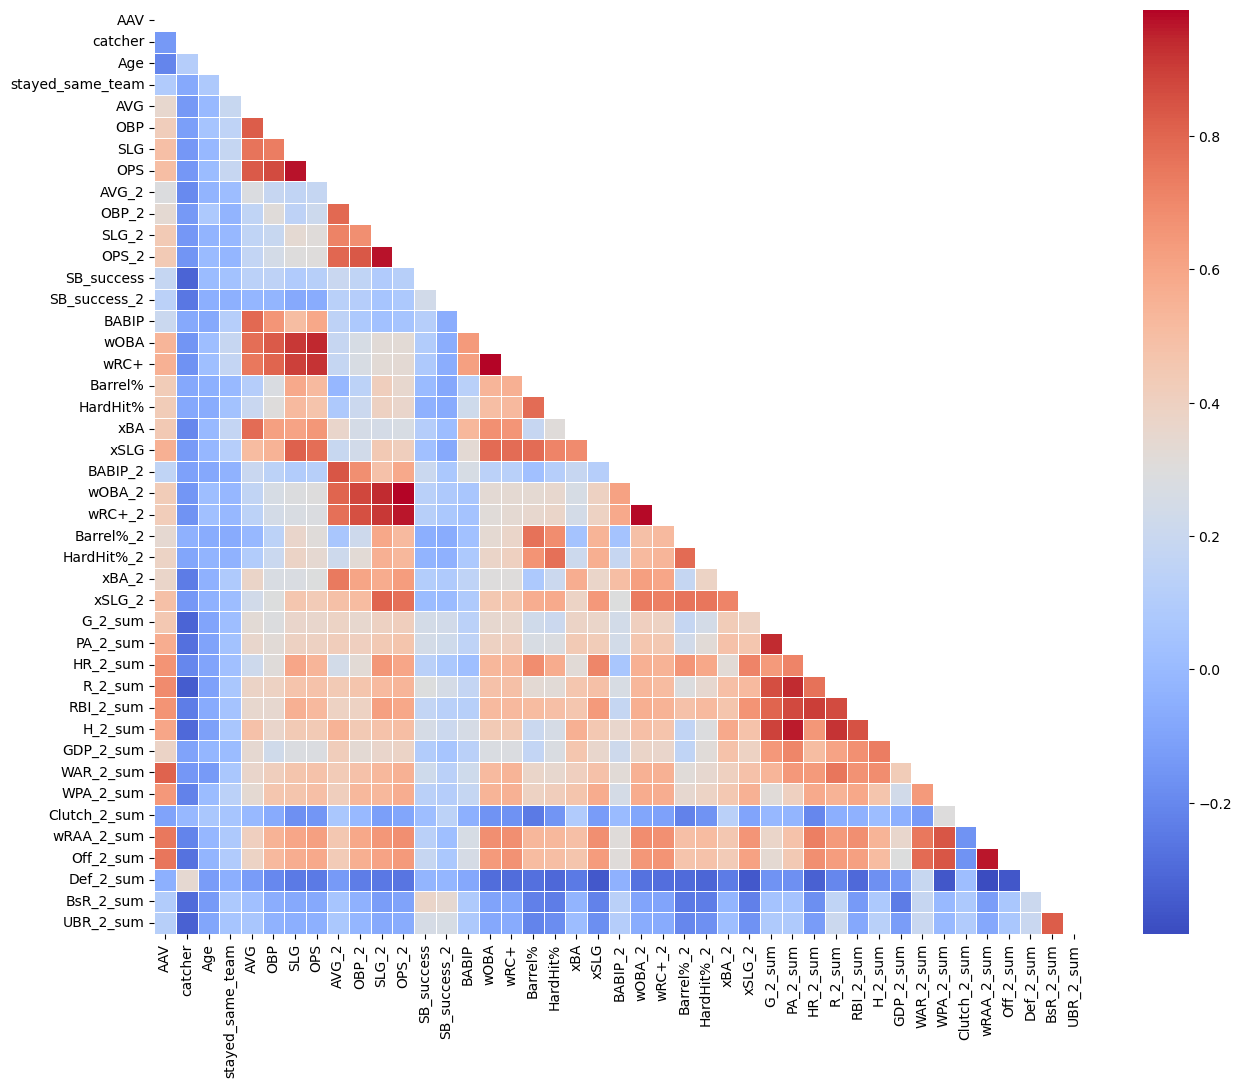

In [29]:
corr_matrix = df2.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 12))


sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=ax)

plt.show()



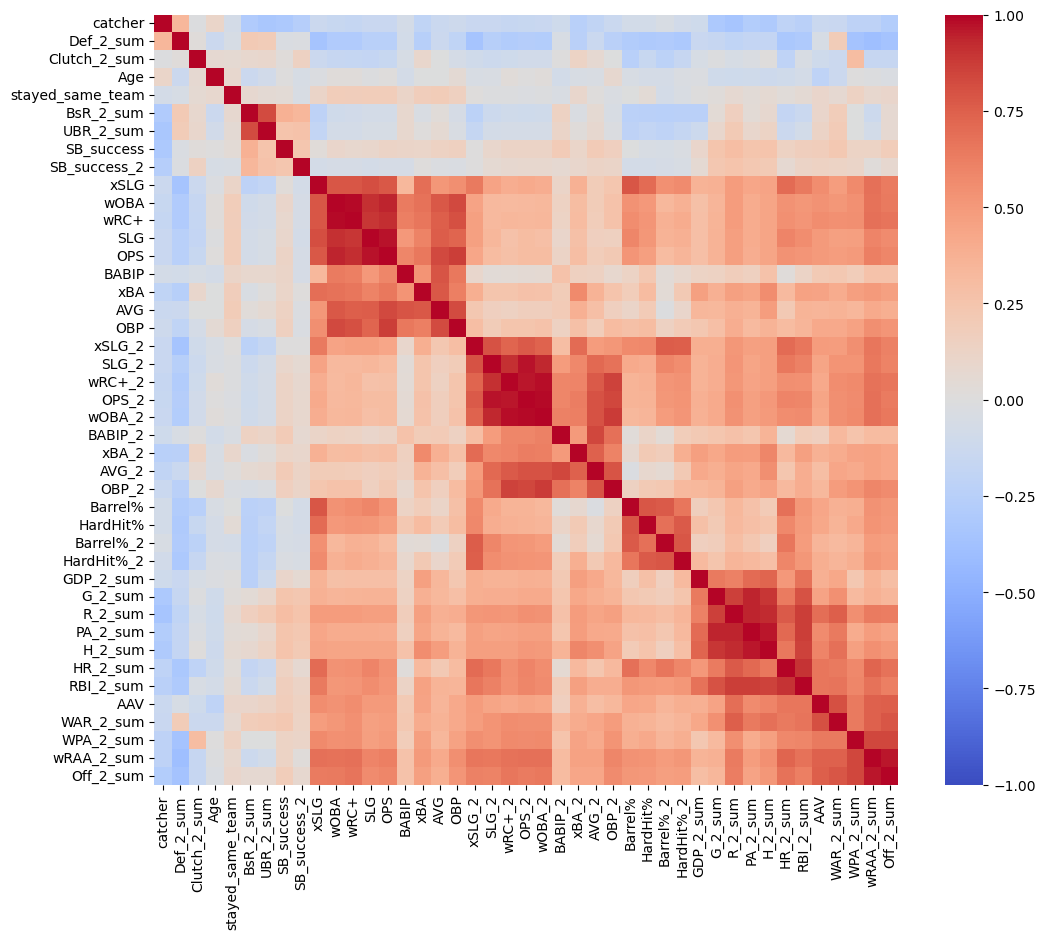

In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(corr_matrix, method='ward')

dendro = dendrogram(linked, no_plot=True)
reordered_corr_matrix = corr_matrix.iloc[dendro['leaves'], dendro['leaves']]

plt.figure(figsize=(12, 10))

sns.heatmap(reordered_corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)

plt.savefig('corr_matrix_clustered.png')

plt.show()


In [31]:
df2.select_dtypes(include=['number']).corr().style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,Age,AVG,OBP,SLG,OPS,AVG_2,OBP_2,SLG_2,OPS_2,SB_success,SB_success_2,BABIP,wOBA,wRC+,Barrel%,HardHit%,xBA,xSLG,BABIP_2,wOBA_2,wRC+_2,Barrel%_2,HardHit%_2,xBA_2,xSLG_2,G_2_sum,PA_2_sum,HR_2_sum,R_2_sum,RBI_2_sum,H_2_sum,GDP_2_sum,WAR_2_sum,WPA_2_sum,Clutch_2_sum,wRAA_2_sum,Off_2_sum,Def_2_sum,BsR_2_sum,UBR_2_sum
AAV,1.000000,-0.210652,0.350959,0.416660,0.494135,0.499469,0.290532,0.335156,0.440770,0.439463,0.179116,0.137173,0.203326,0.537747,0.555383,0.431452,0.428749,0.446952,0.559170,0.160147,0.429441,0.421483,0.344733,0.388265,0.369707,0.489824,0.451914,0.570088,0.660979,0.690064,0.663410,0.597037,0.379227,0.807999,0.645415,-0.102513,0.747208,0.754166,-0.047937,0.097175,0.122979
Age,-0.210652,1.000000,-0.002500,0.047823,-0.011759,0.007997,-0.031703,0.075300,-0.033302,0.000326,0.006992,-0.051313,-0.073212,0.016852,0.021008,-0.044733,-0.063013,-0.005735,-0.016736,-0.080678,0.017393,0.027939,-0.063345,-0.029527,-0.039731,-0.043478,-0.094821,-0.098901,-0.096307,-0.107435,-0.070400,-0.110523,-0.021111,-0.131454,0.004889,0.065283,-0.012483,-0.026496,-0.130216,-0.132076,-0.089839
AVG,0.350959,-0.002500,1.000000,0.825766,0.757979,0.830329,0.283725,0.157273,0.157305,0.169406,0.139274,-0.020719,0.794430,0.775571,0.751554,0.110557,0.195902,0.781051,0.512606,0.197631,0.166601,0.143126,-0.008422,0.101005,0.377001,0.232102,0.328771,0.357344,0.217125,0.381017,0.355650,0.483588,0.342011,0.363643,0.337957,-0.002494,0.407389,0.386506,-0.130945,0.030910,0.062487
OBP,0.416660,0.047823,0.825766,1.000000,0.730538,0.870511,0.185159,0.308354,0.193504,0.246649,0.149527,-0.024320,0.655921,0.829479,0.805775,0.277608,0.302625,0.621243,0.550723,0.141133,0.263820,0.244778,0.144625,0.202404,0.274571,0.292170,0.286732,0.319336,0.311390,0.391024,0.348456,0.364257,0.226691,0.414511,0.460549,-0.070105,0.547046,0.519313,-0.201441,-0.058030,-0.038083
SLG,0.494135,-0.011759,0.757979,0.730538,1.000000,0.972016,0.163070,0.150288,0.338532,0.301841,0.093628,-0.073144,0.505699,0.911527,0.893440,0.586351,0.513890,0.608384,0.812601,0.100822,0.286921,0.272486,0.362874,0.381301,0.275915,0.464514,0.364176,0.398688,0.595481,0.474572,0.557533,0.438709,0.284868,0.465098,0.469707,-0.173189,0.596453,0.567820,-0.248702,-0.074312,-0.050876
OPS,0.499469,0.007997,0.830329,0.870511,0.972016,1.000000,0.181204,0.214371,0.310526,0.302365,0.118915,-0.061107,0.590050,0.942291,0.921105,0.518077,0.474420,0.652179,0.775108,0.121192,0.297520,0.280567,0.311242,0.344390,0.293272,0.435248,0.361115,0.397199,0.536286,0.476549,0.521691,0.441493,0.283307,0.477793,0.496944,-0.148928,0.618049,0.587871,-0.248537,-0.073527,-0.049758
AVG_2,0.290532,-0.031703,0.283725,0.185159,0.163070,0.181204,1.000000,0.794706,0.718463,0.799096,0.195460,0.123799,0.147607,0.187996,0.181052,-0.016305,0.082338,0.364678,0.193544,0.840938,0.802843,0.771265,0.061119,0.216715,0.743432,0.487592,0.385604,0.418301,0.242058,0.442536,0.393531,0.549260,0.419444,0.436243,0.410617,0.067935,0.455671,0.433566,-0.133918,0.055484,0.072716
OBP_2,0.335156,0.075300,0.157273,0.308354,0.150288,0.214371,0.794706,1.000000,0.677872,0.837284,0.156440,0.112000,0.078579,0.260373,0.265214,0.141063,0.205871,0.250253,0.234435,0.680306,0.880806,0.859187,0.220659,0.324610,0.601571,0.511772,0.353463,0.407963,0.325443,0.466480,0.391433,0.446102,0.331074,0.484984,0.528033,-0.004087,0.592057,0.564885,-0.235238,-0.040074,-0.021531
SLG_2,0.440770,-0.033302,0.157305,0.193504,0.338532,0.310526,0.718463,0.677872,1.000000,0.969544,0.092289,0.056342,0.032947,0.323107,0.327754,0.412563,0.396010,0.248522,0.448309,0.485614,0.936732,0.912954,0.592060,0.561932,0.578126,0.803919,0.394779,0.444402,0.653894,0.516840,0.617159,0.475806,0.364161,0.524685,0.527652,-0.118010,0.649797,0.607835,-0.253061,-0.120774,-0.075284
OPS_2,0.439463,0.000326,0.169406,0.246649,0.301841,0.302365,0.799096,0.837284,0.969544,1.000000,0.120761,0.079218,0.050684,0.327048,0.332121,0.353806,0.363070,0.268205,0.411501,0.587797,0.990098,0.965213,0.513821,0.526028,0.630372,0.768369,0.411358,0.4664

OBP and SLG are highly correlated with OPS, which makes sense as OPS is the result of adding both. We knew that from the traditional stats model, but in this one we will stay only with OPS. To OBP and SLG we can add AVG as a highly correlated variable to OPS. 

But wait, all 4 of them seem to be extremely correlated with our new advanced variables wOBA and wRC+. And these two have a higher correlation with our target variable. It is even higher when comparing it to the second season (OPS_2 v wOBA_2 and wRC+_2). It doesn't end there as wOBA and wRC+ are also almost perfectly correlated. wRC+ seems to have a higher correlation to AAV in the closest season, and wOBA in the second to last. To mix it up a little I'll choose wRC+ and wOBA_2.  

WPA_2_sum seems better suited when calculating AAV than Clutch_2_sum in terms of contextual At Bats. 

I realized GDP has more to do with playing time than with actual performance, as its more correlated to PAs than to AAV. 

The high correlation between wRAA and Off is not a surprise. Off has a higher correlation to AAV. 

The last 3 variables show us teams really don't pay for base running or defense. In reality teams are paying pitchers to make their best effort to stop the other team from scoring and pay batters to focus on offense and score as many runs they can. And for base running most teams get a super speedy guy that comes in from the bench to pinch run one inning and thats about it. 

Taking into account we didnt have a single variable that reached a correlation of 0.7 in the traditional stats model, we can start assuming this model will be better. 

In conclusion, the variables selected for this model, according to the previous analysis, eliminating those who are extremely similar to other statistics and trying to pick the one with better correlation with AAV, we have:


catcher, Age, wRC+, xSLG, wOBA_2, xSLG_2 HR_2_sum, R_2_sum, RBI_2_sum, WAR_2_sum, WPA_2_sum, Off_2_sum 

In [32]:
columns_to_keep = ['Name','AAV',
    'catcher', 'Age', 'WAR_2_sum', 'wRC+', 'xSLG', 'wOBA_2', 'xSLG_2',
    'HR_2_sum', 'R_2_sum', 'RBI_2_sum', 'WPA_2_sum', 'Off_2_sum'
]

model_df = df2[columns_to_keep]
model_df.head()

,Name,AAV,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum
0,Shohei Ohtani,35.122807,False,29,10.151636,179.583659,0.638,0.369625,0.549,78,192,190,6.240769,89.395896
1,Cody Bellinger,26.666667,False,28,5.780272,134.283843,0.434,0.284044,0.354,45,165,165,1.137959,18.272228
2,Teoscar Hernandez,23.500000,False,31,4.722464,104.705412,0.476,0.347753,0.501,51,141,170,-0.388117,17.941033
3,Matt Chapman,18.000000,False,31,6.931136,110.043286,0.457,0.330734,0.440,44,149,130,-1.107047,19.770645
4,Rhys Hoskins,17.000000,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726


In [33]:
model_df.select_dtypes(include=['number']).corr().style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum
AAV,1.000000,-0.210652,0.807999,0.555383,0.559170,0.429441,0.489824,0.660979,0.690064,0.663410,0.645415,0.754166
Age,-0.210652,1.000000,-0.131454,0.021008,-0.016736,0.017393,-0.043478,-0.096307,-0.107435,-0.070400,0.004889,-0.026496
WAR_2_sum,0.807999,-0.131454,1.000000,0.542645,0.484167,0.553291,0.480983,0.641926,0.756679,0.669303,0.642037,0.787548
wRC+,0.555383,0.021008,0.542645,1.000000,0.782048,0.337213,0.468325,0.539818,0.487644,0.519948,0.551945,0.669778
xSLG,0.559170,-0.016736,0.484167,0.782048,1.000000,0.396451,0.646696,0.703594,0.491681,0.641071,0.577676,0.636214
wOBA_2,0.429441,0.017393,0.553291,0.337213,0.396451,1.000000,0.739031,0.561645,0.531574,0.562668,0.573903,0.649217
xSLG_2,0.489824,-0.043478,0.480983,0.468325,0.646696,0.739031,1.000000,0.709231,0.514064,0.660701,0.553531,0.615441
HR_2_sum,0.660979,-0.096307,0.641926,0.539818,0.703594,0.561645,0.709231,1.000000,0.767035,0.901025,0.579281,0.677080
R_2_sum,0.690064,-0.107435,0.756679,0.487644,0.491681,0.531574,0.514064,0.767035,1.000000,0.868132,0.549257,0.627657
RBI_2_sum,0.663410,-0.070400,0.669303,0.519948,0.641071,0.562668,0.660701,0.901025,0.868132,1.000000,0.589684,0.620043


In [34]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       420 non-null    object 
 1   AAV        420 non-null    float64
 2   catcher    420 non-null    bool   
 3   Age        420 non-null    int64  
 4   WAR_2_sum  420 non-null    float64
 5   wRC+       420 non-null    float64
 6   xSLG       420 non-null    float64
 7   wOBA_2     420 non-null    float64
 8   xSLG_2     420 non-null    float64
 9   HR_2_sum   420 non-null    int64  
 10  R_2_sum    420 non-null    int64  
 11  RBI_2_sum  420 non-null    int64  
 12  WPA_2_sum  420 non-null    float64
 13  Off_2_sum  420 non-null    float64
dtypes: bool(1), float64(8), int64(4), object(1)
memory usage: 43.2+ KB


## DF TO CSV

In [35]:
model_df.to_csv('advmodel_df.csv', index=False)

In [36]:
target = "AAV"
features = [col for col in model_df.columns if col != target and col!= "Name"]
X, y = model_df[features], model_df[target]

## Train-Test Split

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (336, 12)
X_test shape: (84, 12)
y_train shape: (336,)
y_test shape: (84,)


### Distribution of y train values

C:\Users\mfran\AppData\Local\Temp\ipykernel_12580\3840007699.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, shade=True)


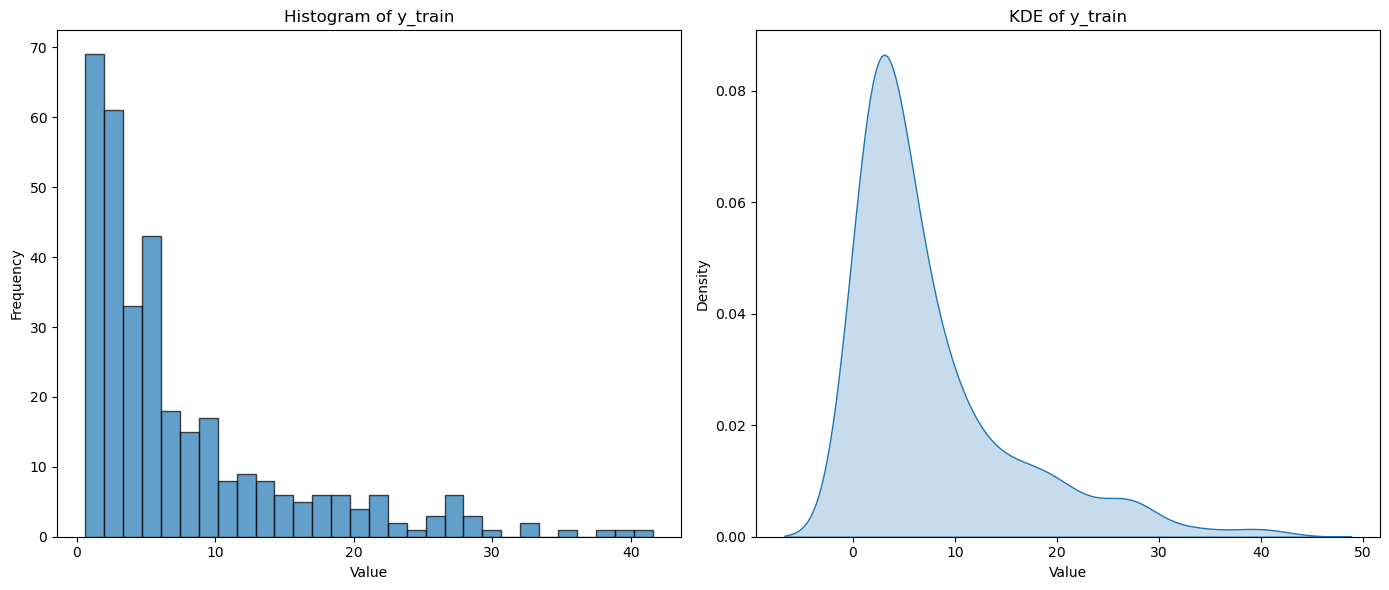

In [38]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_train, shade=True)
plt.title('KDE of y_train')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Distribution of test values 

C:\Users\mfran\AppData\Local\Temp\ipykernel_12580\893388450.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True)


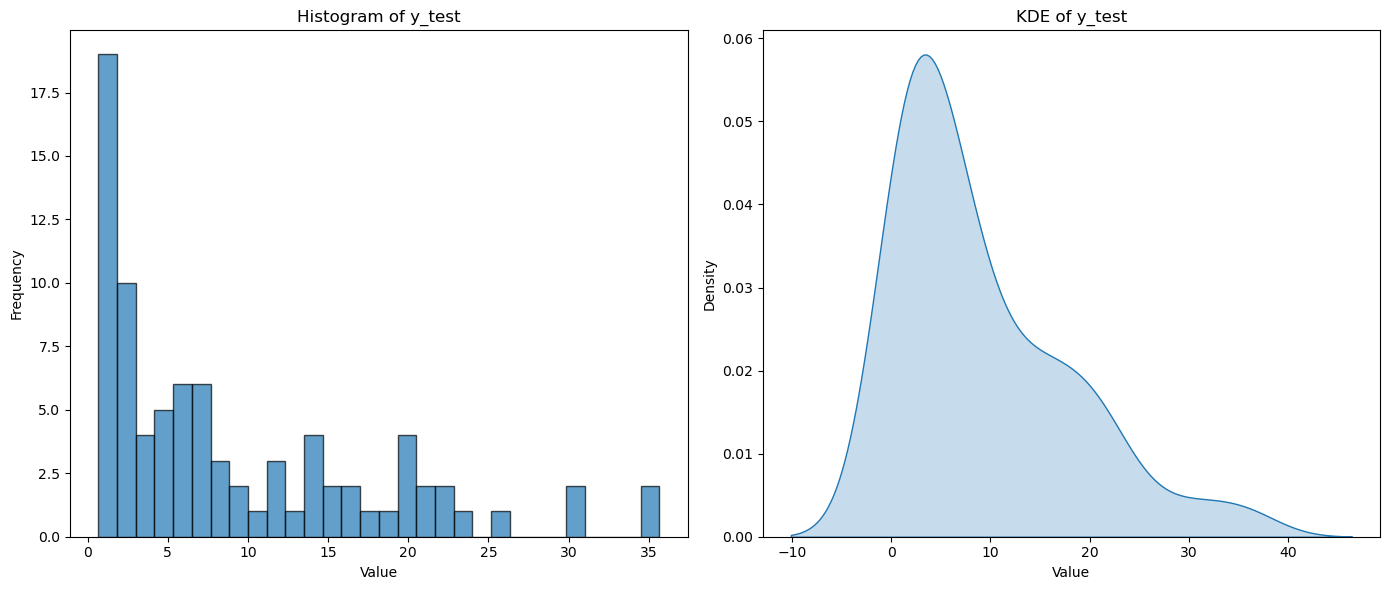

In [39]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_test, shade=True)
plt.title('KDE of y_test')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

## Linear Model

In [40]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [41]:
linear_model.coef_, linear_model.intercept_

(array([ 1.75378320e+00, -2.69308296e-01,  1.21298836e+00, -7.30281798e-03,
         5.01378643e+00, -4.22423386e+01,  6.51637670e+00, -9.89513968e-03,
         2.41889808e-02,  1.85074666e-02,  1.76722515e-01,  1.30579424e-01]),
 17.717106026338882)

In [42]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,5.496499,2.506934,31.323235
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,0.012328,1.523658,99.197391
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,7.206196,-0.706196,-10.864548
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,13.817765,5.976063,30.191549
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,12.284393,4.715607,27.738865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,False,34,0.109695,100.814827,0.375,0.310525,0.375,18,78,108,1.771367,-4.749255,1.415992,2.564262,-1.148270,-81.092986
250,False,32,3.842026,84.629899,0.386,0.308384,0.374,20,95,97,-2.330405,-16.007325,6.240850,5.880317,0.360533,5.776987
90,True,30,0.294800,43.905866,0.261,0.227140,0.287,17,58,61,-2.697999,-44.632429,4.971162,1.071292,3.899870,78.449870
326,False,31,3.039718,125.157323,0.549,0.327248,0.442,69,156,172,0.401020,22.426822,14.638776,13.224140,1.414636,9.663623


### Evaluation Metrics

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.737488435224078
MAPE: 0.781755241265357
R^2: 0.7003139866614149


From the start we have a better model than the one we had with the traditional stats. 

The RMSE behaved in a similar way as we are failing by 4.73 on average (we had 4.99 in comparison). The MAPE in this case is significantly lower, 106% on average to 78%. Finally the R^2 score saw the biggest improvement, from 0.60 to 0.70.

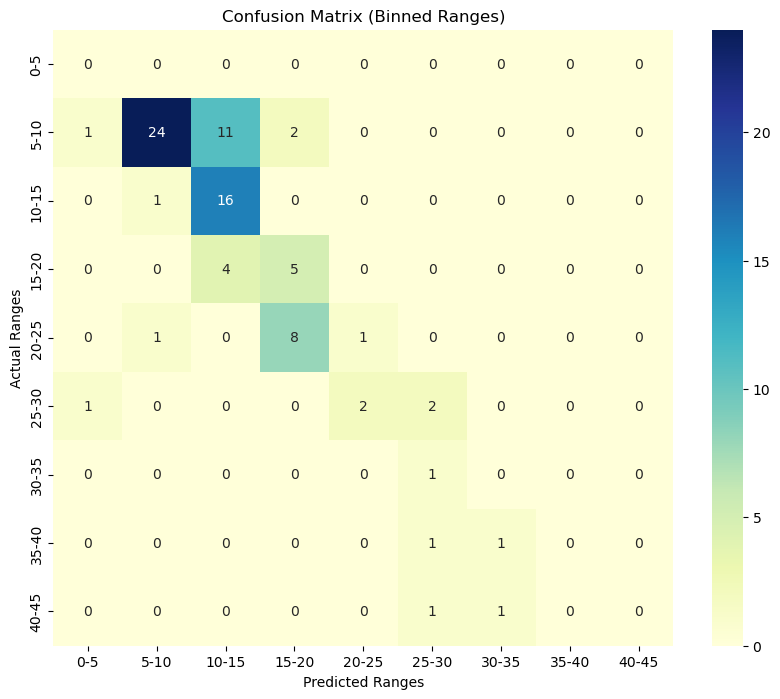

In [44]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
linear_y_pred_binned = bin_values(linear_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, linear_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

#### Correction for negative predictions (Linear Regression)

In [45]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [46]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,3.445761,4.557672,56.946464
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,0.594879,0.941107,61.270554
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,4.815392,1.684608,25.917040
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,10.529421,9.264407,46.804523
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,6.145995,10.854005,63.847086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,False,34,0.109695,100.814827,0.375,0.310525,0.375,18,78,108,1.771367,-4.749255,1.415992,2.505187,-1.089195,-76.920955
250,False,32,3.842026,84.629899,0.386,0.308384,0.374,20,95,97,-2.330405,-16.007325,6.240850,4.637191,1.603659,25.696163
90,True,30,0.294800,43.905866,0.261,0.227140,0.287,17,58,61,-2.697999,-44.632429,4.971162,2.280184,2.690978,54.131771
326,False,31,3.039718,125.157323,0.549,0.327248,0.442,69,156,172,0.401020,22.426822,14.638776,10.564512,4.074264,27.832000


In [47]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 5.231570574625012
MAPE: 0.5505652447166964
R^2: 0.6345446486794648


In [48]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


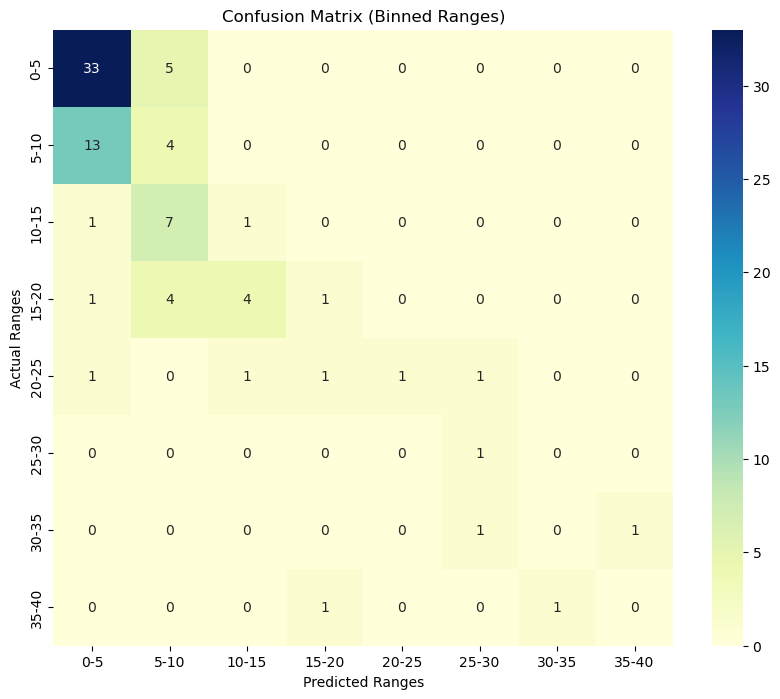

In [49]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
linear_y_pred_binned = bin_values(linear_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, linear_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

### XGBoost Model

In [50]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,3.702405,4.301028,53.739793
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,1.197489,0.338496,22.037732
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,4.151913,2.348087,36.124413
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,14.706439,5.087389,25.701895
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,15.107041,1.892959,11.135051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,False,34,0.109695,100.814827,0.375,0.310525,0.375,18,78,108,1.771367,-4.749255,1.415992,2.388477,-0.972485,-68.678728
250,False,32,3.842026,84.629899,0.386,0.308384,0.374,20,95,97,-2.330405,-16.007325,6.240850,5.318887,0.921962,14.773028
90,True,30,0.294800,43.905866,0.261,0.227140,0.287,17,58,61,-2.697999,-44.632429,4.971162,4.166047,0.805115,16.195702
326,False,31,3.039718,125.157323,0.549,0.327248,0.442,69,156,172,0.401020,22.426822,14.638776,10.834575,3.804202,25.987156


In [51]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 4.684851602675679
MAPE: 0.6104043194835902
R^2: 0.7069364363788808


The XGBoost model performed better in every aspect. In terms of RMSE we have 4.68, similar to the linear model, but significantly better than XGBoost model with traditional stats (5.73). The average deviation (MAPE) saw a big decrease (0,61 compared to 0,78 and 0,87 respectively. And R^2 score increase slightly to .706.

#### Testing 0-5 range values

In [52]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()

correct_predictions = results_df_xgb['in_range'].sum()

print(f'Number of Real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of Real values in the range 0-5: 38
Number of correct predictions in the range 0-5: 29


#### All ranges visualized with a bar plot

   Range  Total Real in Range  Correct_Predictions
0    0-5                   38                   29
1   5-10                   17                   10
2  10-15                   10                    2
3  15-20                   10                    4
4  20-25                    5                    0
5  25-30                    1                    1
6  30-35                    2                    1
7  35-40                    2                    0
8    40+                    0                    0


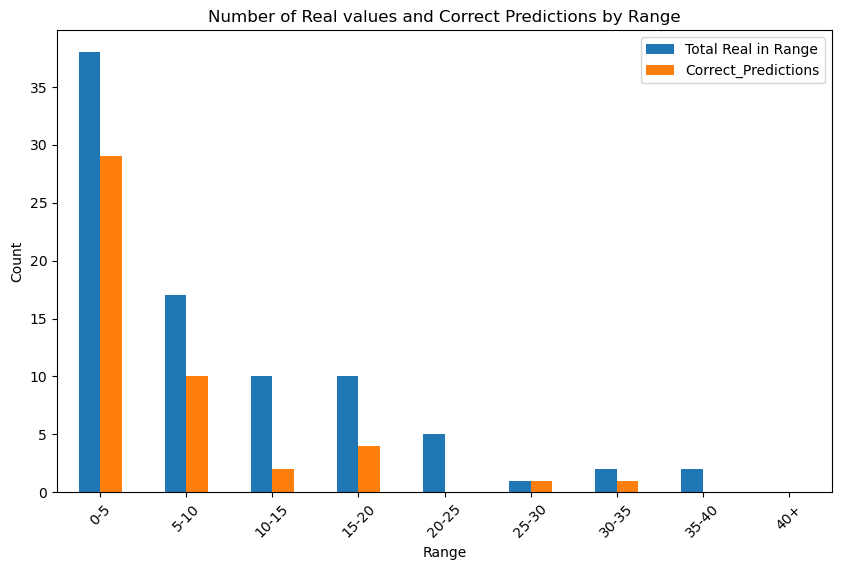

In [53]:
ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()
    
    correct_predictions = results_df_xgb['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in Range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix 

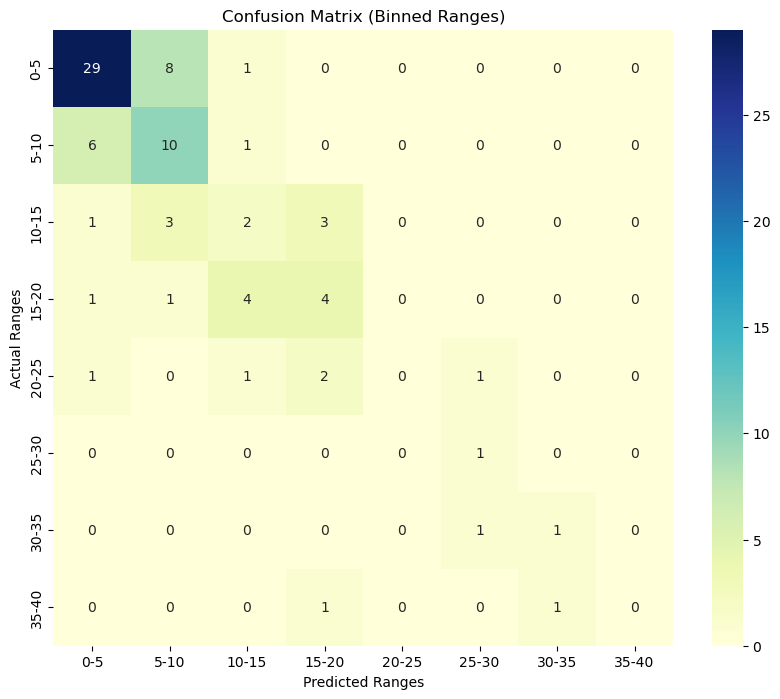

In [54]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
xgb_y_pred_binned = bin_values(xgb_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, xgb_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

#### Correction for negative predictions (XGBoost Regression)

In [55]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


## Ridge Regression

In [56]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,5.830530,2.172903,27.149636
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,-2.647774,4.183759,272.382737
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,7.940378,-1.440378,-22.159654
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,13.095761,6.698067,33.839170
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,12.657359,4.342641,25.544945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,False,34,0.109695,100.814827,0.375,0.310525,0.375,18,78,108,1.771367,-4.749255,1.415992,2.991662,-1.575670,-111.276765
250,False,32,3.842026,84.629899,0.386,0.308384,0.374,20,95,97,-2.330405,-16.007325,6.240850,6.274371,-0.033521,-0.537119
90,True,30,0.294800,43.905866,0.261,0.227140,0.287,17,58,61,-2.697999,-44.632429,4.971162,-0.017444,4.988606,100.350914
326,False,31,3.039718,125.157323,0.549,0.327248,0.442,69,156,172,0.401020,22.426822,14.638776,12.926876,1.711901,11.694289


In [57]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 4.923020118004483
MAPE: 0.8634394774252789
R^2: 0.6763814781610824


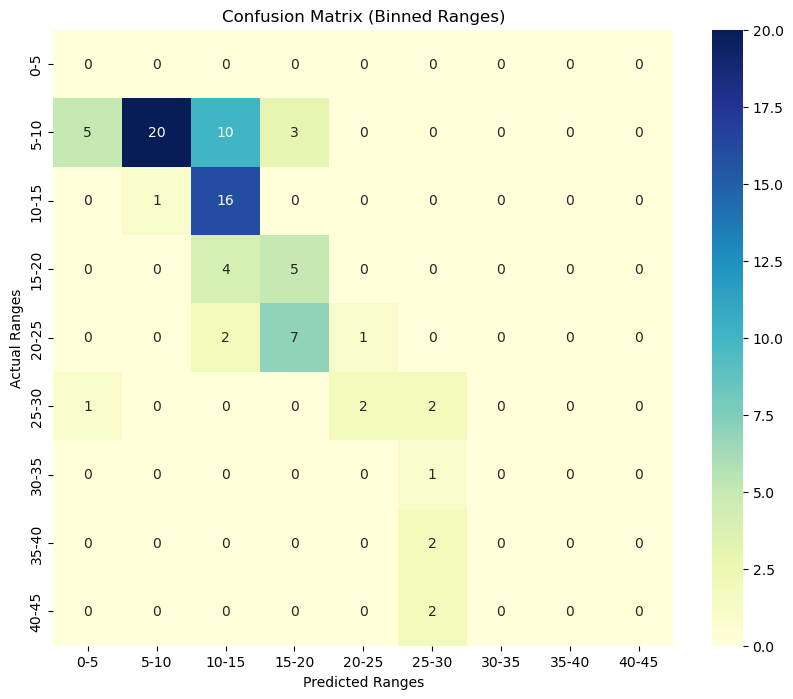

In [58]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
ridge_y_pred_binned = bin_values(ridge_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, ridge_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

#### Correction for negative predictions

In [59]:
negative_values_exist = (results_df_ridge["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [60]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


y_train_log = np.log(y_train)


ridge_model = Ridge()
ridge_model.fit(X_train, y_train_log)


ridge_y_pred_log = ridge_model.predict(X_test)


ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test)) 

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")


results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 5.228459789381108
MAPE: 0.5615476556936045
R^2: 0.6349791320153599


,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,3.681667,4.321766,53.998898
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,0.579969,0.956017,62.241271
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,5.238315,1.261685,19.410534
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,10.148991,9.644837,48.726488
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,6.222663,10.777337,63.396098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,False,34,0.109695,100.814827,0.375,0.310525,0.375,18,78,108,1.771367,-4.749255,1.415992,2.656505,-1.240513,-87.607352
250,False,32,3.842026,84.629899,0.386,0.308384,0.374,20,95,97,-2.330405,-16.007325,6.240850,4.563661,1.677189,26.874366
90,True,30,0.294800,43.905866,0.261,0.227140,0.287,17,58,61,-2.697999,-44.632429,4.971162,2.350914,2.620247,52.708957
326,False,31,3.039718,125.157323,0.549,0.327248,0.442,69,156,172,0.401020,22.426822,14.638776,10.119457,4.519320,30.872251


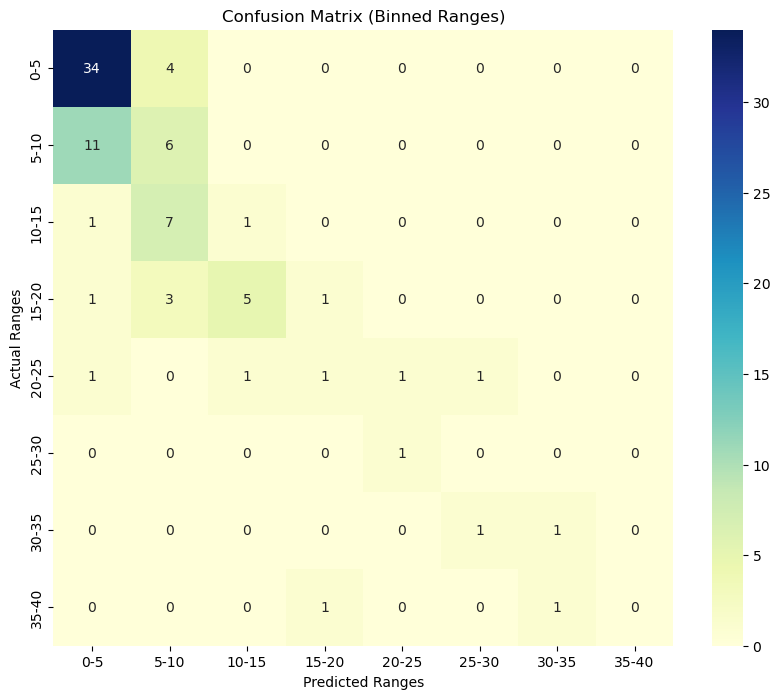

In [61]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
ridge_y_pred_binned = bin_values(ridge_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, ridge_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()

### Min Max Scaling

In [62]:
y_train_log = np.log(y_train)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train_log)

ridge_y_pred_log = ridge_model.predict(X_test_scaled)

ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test))

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 5.295457355218388
MAPE: 0.5556888369325105
R^2: 0.6255644296867711


,catcher,Age,WAR_2_sum,wRC+,xSLG,wOBA_2,xSLG_2,HR_2_sum,R_2_sum,RBI_2_sum,WPA_2_sum,Off_2_sum,y_real,y_pred,err,%_err
378,False,32,1.690518,109.537260,0.360,0.302992,0.360,25,93,80,-0.445498,2.992722,8.003433,3.610399,4.393034,54.889371
165,False,28,-0.936736,-60.467239,0.132,0.278556,0.363,7,32,32,-0.625584,-14.675757,1.535986,0.709087,0.826899,53.835052
17,False,32,2.762809,92.328774,0.366,0.346548,0.438,49,122,132,-1.572710,5.732043,6.500000,5.207492,1.292508,19.884744
179,False,33,3.576538,115.407509,0.517,0.336945,0.493,55,153,201,3.140679,19.063207,19.793828,11.238855,8.554973,43.220409
4,False,31,4.732510,122.328017,0.445,0.345172,0.445,30,81,79,2.942371,29.668726,17.000000,6.062693,10.937307,64.337101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,False,34,0.109695,100.814827,0.375,0.310525,0.375,18,78,108,1.771367,-4.749255,1.415992,2.788022,-1.372030,-96.895288
250,False,32,3.842026,84.629899,0.386,0.308384,0.374,20,95,97,-2.330405,-16.007325,6.240850,4.209518,2.031332,32.548961
90,True,30,0.294800,43.905866,0.261,0.227140,0.287,17,58,61,-2.697999,-44.632429,4.971162,2.285256,2.685906,54.029745
326,False,31,3.039718,125.157323,0.549,0.327248,0.442,69,156,172,0.401020,22.426822,14.638776,11.410239,3.228538,22.054695


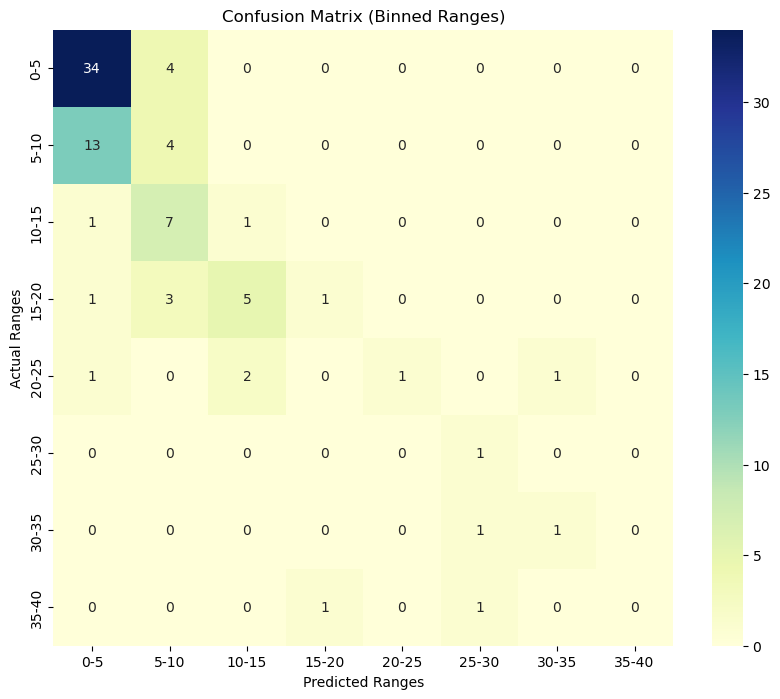

In [63]:
def bin_values(values, bin_size):
    return np.floor(values / bin_size).astype(int)

bin_size = 5
y_test_binned = bin_values(y_test, bin_size)
ridge_y_pred_binned = bin_values(ridge_y_pred, bin_size)

conf_matrix = confusion_matrix(y_test_binned, ridge_y_pred_binned)

bins = range(conf_matrix.shape[0])
bin_labels = [f'{i*bin_size}-{(i+1)*bin_size}' for i in bins]
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels, columns=bin_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix (Binned Ranges)')
plt.xlabel('Predicted Ranges')
plt.ylabel('Actual Ranges')
plt.show()